In [1]:
#kiểm tra CUDA
!nvidia-smi

Fri Mar  3 14:14:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 38%   37C    P8    10W / 120W |     64MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#import thư viện
import torch
import torchvision
import onnx
import time

In [4]:
import torch
import torchvision
#tải mô hình đã được đào tạo sẵn 
resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model.eval()

Using cache found in /home/haobk/.cache/torch/hub/pytorch_vision_v0.10.0
/home/haobk/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/haobk/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Tạo folder data, tải ảnh và nhãn

In [7]:
!mkdir -p ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

In [10]:
#Kiểm tra ảnh
!ls ./data

imagenet_class_index.json  img0.JPG  img1.JPG  img2.JPG  img3.JPG


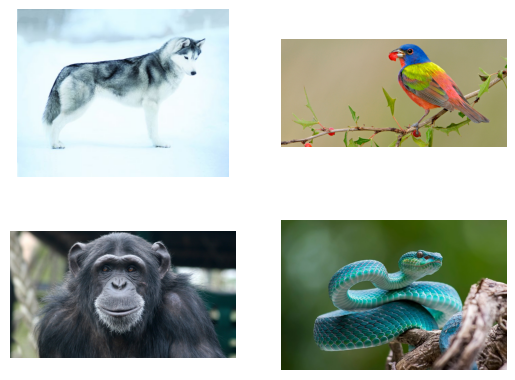

In [5]:
# Hiển thị nhãn và ảnh
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')

# đọc nhãn
with open("./data/imagenet_class_index.json") as json_file:
    d = json.load(json_file)

In [16]:
#hiển thị  nhãn
d

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

# Chạy mô hình pytorch và đo thời gian

In [15]:
import numpy as np
import time
import torch.backends.cudnn as cudnn
import onnxruntime
cudnn.benchmark = True

#Tiền xử lí bằng transform cho pytorch
def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

# gọi tiền xử lí và cho qua mô hình dự đoán kết quả
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # đưa dữ liệu về batch=1

    # chuyển mô hình và dữ liệu về cuda
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        # lấy kết quả từ mô hình
        output = model(input_batch)
        # Chuyển kết quả về đầu ra xác suất bằng softmax
        sm_output = torch.nn.functional.softmax(output[0], dim=0)

    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] # # đầu ra là tên class và xác suất

def benchmark_torch(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Vòng lặp %d/%d, thời gian trung bình %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Kích thước dữ liệu:", input_data.size())
    print('Thời gian trung bình : %.2f ms'%(np.mean(timings)*1000))


./data/img0.JPG - Nhãn dự đoán: ['n02110185', 'Siberian_husky'], Xác suất: 0.4978733956813812
./data/img1.JPG - Nhãn dự đoán: ['n01820546', 'lorikeet'], Xác suất: 0.6447010040283203
./data/img2.JPG - Nhãn dự đoán: ['n02481823', 'chimpanzee'], Xác suất: 0.9899841547012329
./data/img3.JPG - Nhãn dự đoán: ['n01749939', 'green_mamba'], Xác suất: 0.394700825214386


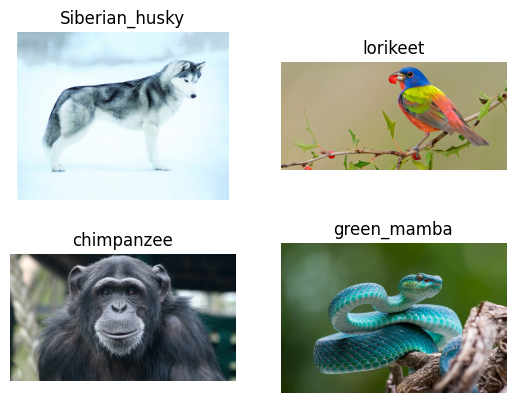

In [7]:
# chạy thử ảnh trong tập data và hiển thị kết quả
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)

    pred, prob = predict(img_path, resnet50_model)
    print('{} - Nhãn dự đoán: {}, Xác suất: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(pred[1])

In [8]:
# Đo thời gian của mô hình pytorch
model = resnet50_model.eval().to("cuda")
benchmark(model, input_shape=(8, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Vòng lặp 10/100, thời gian trung bình 28.80 ms
Vòng lặp 20/100, thời gian trung bình 28.80 ms
Vòng lặp 30/100, thời gian trung bình 28.80 ms
Vòng lặp 40/100, thời gian trung bình 28.83 ms
Vòng lặp 50/100, thời gian trung bình 28.84 ms
Vòng lặp 60/100, thời gian trung bình 28.85 ms
Vòng lặp 70/100, thời gian trung bình 28.86 ms
Vòng lặp 80/100, thời gian trung bình 28.86 ms
Vòng lặp 90/100, thời gian trung bình 28.87 ms
Vòng lặp 100/100, thời gian trung bình 28.87 ms
Kích thước dữ liệu: torch.Size([8, 3, 224, 224])
Thời gian trung bình : 28.87 ms
